In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
import IPython as ip
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
mpl.style.use('ggplot')
mpl.rc('figure', figsize=(7.2, 5.76))
mpl.rc('font', family='Noto Sans CJK TC')
plt.rc('lines', markeredgecolor='white', markeredgewidth=0.75)
plt.rc('patch', edgecolor='white', force_edgecolor=True, linewidth=1)
ip.display.set_matplotlib_formats('svg')

In [3]:
from sklearn import discriminant_analysis
from sklearn import linear_model
from sklearn import svm
from sklearn import neighbors
from sklearn import ensemble
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import feature_selection
from sklearn import pipeline
from sklearn import metrics

In [4]:
m = sm.datasets.anes96
df = m.load_pandas().data
df_raw = df

In [5]:
df = df_raw
df_X = df[[c for c in df.columns if c != 'vote']]
s_y = df.vote
X_raw = df_X.values
y_raw = s_y.values

In [6]:
# keep our own testing set to have a correct testing set metrics
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_raw, y_raw, test_size=0.4, random_state=20200503
)

In [7]:
def get_pipe_name(pipe):
    return '-'.join(s[0] for s in pipe.steps)

In [8]:
pipe_list_1 = [
    pipeline.make_pipeline(discriminant_analysis.LinearDiscriminantAnalysis()),
    pipeline.make_pipeline(
        preprocessing.StandardScaler(),
        linear_model.LogisticRegression(random_state=20201017)
    ),
    # # lost
    # pipeline.make_pipeline(
    #     preprocessing.MinMaxScaler(),
    #     linear_model.LogisticRegression(random_state=20201017)
    # ),
    # # lost
    # pipeline.make_pipeline(
    #     preprocessing.StandardScaler(),
    #     svm.LinearSVC(random_state=20200503),
    # ),
    pipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        svm.LinearSVC(random_state=20200503),
    ),
    # # lost
    # pipeline.make_pipeline(
    #     preprocessing.StandardScaler(),
    #     neighbors.KNeighborsClassifier(),
    # ),
    pipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        neighbors.KNeighborsClassifier(),
    ),
    pipeline.make_pipeline(
        preprocessing.MinMaxScaler(),
        svm.SVC(kernel='rbf', random_state=20200503),
    ),
    pipeline.make_pipeline(
        ensemble.RandomForestClassifier(random_state=20200503),
    ),
    pipeline.make_pipeline(
        ensemble.GradientBoostingClassifier(random_state=20200503),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        preprocessing.MinMaxScaler(),
        svm.LinearSVC(random_state=20200503),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        preprocessing.MinMaxScaler(),
        neighbors.KNeighborsClassifier(),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        preprocessing.MinMaxScaler(),
        svm.SVC(kernel='rbf', random_state=20200503),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        ensemble.RandomForestClassifier(random_state=20200503),
    ),
    pipeline.make_pipeline(
        feature_selection.SelectKBest(feature_selection.f_classif, k=3),
        ensemble.GradientBoostingClassifier(random_state=20200503),
    ),
]

cv_list_1 = [
    # cv will split our `train` into its `train`/`test`
    # cv's `test` is also called “validation set”
    model_selection.cross_validate(pipe, X_train, y_train,
                                   return_train_score=True)
    for pipe in pipe_list_1
]

Check the overall performances:

,pipe_name,n,fit_time,score_time,test_score,train_score
0,lineardiscriminantanalysis,0,0.002056,0.000356,0.938596,0.922566
1,lineardiscriminantanalysis,1,0.001251,0.000279,0.902655,0.938190
2,lineardiscriminantanalysis,2,0.001360,0.000417,0.920354,0.933775
3,lineardiscriminantanalysis,3,0.001416,0.000384,0.973451,0.913907
4,lineardiscriminantanalysis,4,0.001541,0.000349,0.902655,0.935982
...,...,...,...,...,...,...
55,selectkbest-gradientboostingclassifier,0,0.063816,0.000878,0.938596,0.951327
56,selectkbest-gradientboostingclassifier,1,0.066275,0.000776,0.884956,0.958057
57,selectkbest-gradientboostingclassifier,2,0.063959,0.000794,0.929204,0.953642
58,selectkbest-gradientboostingclassifier,3,0.060185,0.000909,0.973451,0.944812


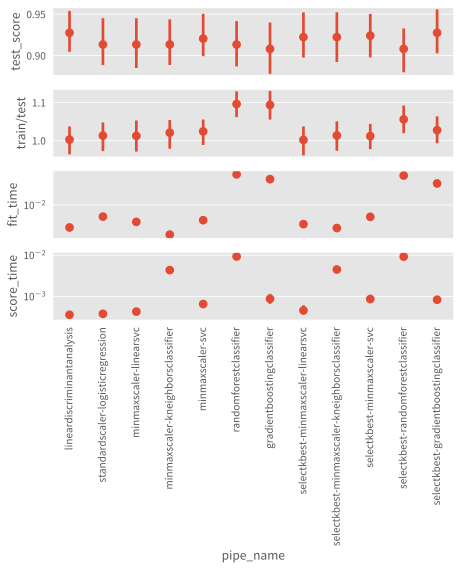

In [9]:
df = pd.concat(map(pd.DataFrame, cv_list_1),
               keys=map(get_pipe_name, pipe_list_1),
               names=['pipe_name', 'n'])
df = df.reset_index()
with pd.option_context('display.max_rows', 10):  # just tl;dr
    display(df)
cv_1_df = df

fig, (ax_1, ax_2, ax_3, ax_4) = plt.subplots(4, 1, sharex=True)

sns.pointplot(data=df, x='pipe_name', y='test_score', join=False, ax=ax_1)
ax_1.set_xlabel('')

# check for overfitting: the train/test should be around 1
sns.pointplot(data=df, x='pipe_name', y=df.train_score/df.test_score, join=False, ax=ax_2)
ax_2.set_xlabel('')
ax_2.set_ylabel('train/test')

sns.pointplot(data=df, x='pipe_name', y='fit_time', join=False, ax=ax_3)
ax_3.set_yscale('log')
ax_3.set_xlabel('')

sns.pointplot(data=df, x='pipe_name', y='score_time', join=False, ax=ax_4)
ax_4.set_yscale('log')

plt.xticks(rotation=90)
plt.show()

Select the best pipeline by _test_score/time_:

In [10]:
df = cv_1_df
df = (df
      .groupby('pipe_name')
      [['test_score', 'fit_time', 'score_time']]
      .mean())
df = df.assign(test_score_per_time=df.test_score/(df.fit_time+df.score_time))
df = df.sort_values('test_score_per_time', ascending=False)
display(df)

pipe_name = df.index[0]
pipe = next(pipe
            for pipe in pipe_list_1
            if get_pipe_name(pipe) == pipe_name)

pipe.fit(X_train, y_train)
y_test_hat = pipe.predict(X_test)

print(f'Our own testing set metrics of the best pipeline ({pipe_name}) by test_score/time:\n')
print(metrics.classification_report(y_test, y_test_hat))

,test_score,fit_time,score_time,test_score_per_time
pipe_name,,,,
lineardiscriminantanalysis,0.927542,0.001525,0.000357,492.879239
selectkbest-minmaxscaler-linearsvc,0.922264,0.002020,0.000457,372.326988
minmaxscaler-linearsvc,0.913399,0.002437,0.000427,318.974169
minmaxscaler-svc,0.920494,0.002820,0.000652,265.130508
standardscaler-logisticregression,0.913399,0.003801,0.000377,218.603562
selectkbest-minmaxscaler-svc,0.924034,0.003742,0.000860,200.795662
minmaxscaler-kneighborsclassifier,0.913414,0.000835,0.004346,176.301449
selectkbest-minmaxscaler-kneighborsclassifier,0.922279,0.001451,0.004493,155.154786
selectkbest-gradientboostingclassifier,0.927542,0.062445,0.000830,14.658884


Our own testing set metrics of the best pipeline (lineardiscriminantanalysis) by test_score/time:

              precision    recall  f1-score   support

         0.0       0.94      0.88      0.91       226
         1.0       0.83      0.91      0.87       152

    accuracy                           0.89       378
   macro avg       0.89      0.90      0.89       378
weighted avg       0.90      0.89      0.89       378



Try if _precision_ or _recall_ is more important:

In [11]:
# metrics.SCORERS.keys()
# metrics.SCORERS['precision_macro']
# # -> make_scorer(precision_score, average=binary)

# the `cv_list` uses the different scorings from the above one
cv_list = [
    model_selection.cross_validate(pipe, X_train, y_train,
                                   scoring=['precision_macro',
                                            'recall_macro',
                                            'f1_macro'])
    for pipe in pipe_list_1
]

df = pd.concat(map(pd.DataFrame, cv_list),
               keys=map(get_pipe_name, pipe_list_1),
               names=['pipe_name', 'n'])
df = df.reset_index()

df = (df
      .groupby('pipe_name')
      [['test_precision_macro', 'test_recall_macro', 'test_f1_macro']]
      .mean())

print('If precision_macro is more important:')
df = df.sort_values('test_precision_macro', ascending=False)
display(df.tail(3))

print('If recall_macro is more important:')
df = df.sort_values('test_recall_macro', ascending=False)
display(df.tail(3))

If precision_macro is more important:


,test_precision_macro,test_recall_macro,test_f1_macro
pipe_name,,,
minmaxscaler-kneighborsclassifier,0.911111,0.914935,0.912109
selectkbest-randomforestclassifier,0.907419,0.904326,0.905509
gradientboostingclassifier,0.907199,0.906548,0.905985


If recall_macro is more important:


,test_precision_macro,test_recall_macro,test_f1_macro
pipe_name,,,
standardscaler-logisticregression,0.912397,0.911121,0.911383
gradientboostingclassifier,0.907199,0.906548,0.905985
selectkbest-randomforestclassifier,0.907419,0.904326,0.905509
